# 02 – Advanced Feature Building

## Purpose
This notebook enriches firmware data with **advanced synthetic features** for ML modeling:
- **Firmware metadata**: patch type, code churn, file/line changes
- **Device inventory**: hardware revisions, manufacturing dates, regional distribution

## Inputs
- SQLite database (populated by notebook 01)

## Outputs
- `data/Processed/firmware_metadata.csv`
- `data/Processed/device_inventory.csv`
- Updated SQLite tables

---

## 1. Setup & Configuration

In [39]:
# Standard imports
import numpy as np
import pandas as pd
import sqlite3
import sys
from pathlib import Path

# Add project root to path
current_dir = Path.cwd()
project_root = current_dir.parents[0] if current_dir.name == "notebooks" else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.config import DB_PATH, PROCESSED_DATA_DIR, RANDOM_SEED

# Connect to database
conn = sqlite3.connect(DB_PATH)

def q(sql: str) -> pd.DataFrame:
    """Execute SQL query and return DataFrame"""
    return pd.read_sql_query(sql, conn)

# Load base tables
firmware_releases = q("SELECT * FROM firmware_releases;")
device_events = q("SELECT * FROM device_events;")

print(f"✅ Configuration loaded")
print(f"🗄️  Database: {DB_PATH}")
print(f"📁 Output: {PROCESSED_DATA_DIR}")
print(f"\\nLoaded {len(firmware_releases)} firmware releases and {len(device_events):,} device events")

firmware_releases.head()

✅ Configuration loaded
🗄️  Database: /Users/hc/Documents/projects/roku-patch-stability-analytics/db/roku_telemetry.db
📁 Output: /Users/hc/Documents/projects/roku-patch-stability-analytics/data/Processed
\nLoaded 50 firmware releases and 2,450 device events


,firmware_version,release_date,previous_version,days_since_previous_release
0,10.0.1,2024-01-30,9.9.9,90.0
1,10.0.2,2024-02-22,10.0.1,23.0
2,10.1.0,2024-03-15,10.0.2,22.0
3,10.1.1,2024-04-06,10.1.0,22.0
4,10.2.0,2024-05-16,10.1.1,40.0


## 2. Generate Synthetic Firmware Metadata

Create enriched firmware features with realistic correlations between patch characteristics and risk.

In [40]:
# --- Firmware metadata synthesis ---

# 1) Ensure release_date is datetime and sort chronologically
firmware_releases["release_date"] = pd.to_datetime(firmware_releases["release_date"])
fr = firmware_releases.sort_values("release_date").reset_index(drop=True)

# 2) Previous version + days since previous release
fr["previous_version"] = fr["firmware_version"].shift(1)
fr["days_since_previous_release"] = (
    fr["release_date"] - fr["release_date"].shift(1)
).dt.days

# For the very first release, avoid NaNs / divide-by-zero later
fr.loc[0, "days_since_previous_release"] = np.nan  # keep as NaN for now

# 3) Patch type (categorical)
rng = np.random.default_rng(seed=42)

patch_types = ["bugfix", "feature", "security", "hotfix"]
patch_probs = [0.60, 0.20, 0.10, 0.10]  # sums to 1.0

fr["patch_type"] = rng.choice(patch_types, size=len(fr), p=patch_probs)

# 4) Patch size (MB) with correlation to patch_type
base_sizes = rng.uniform(10, 250, size=len(fr))

size_multipliers = {
    "bugfix": 0.8,
    "feature": 1.2,
    "security": 1.0,
    "hotfix": 0.9,
}

fr["patch_size_mb"] = [
    base_sizes[i] * size_multipliers[pt] for i, pt in enumerate(fr["patch_type"])
]

# 5) Files changed ~ Poisson correlated with patch_size_mb
# Rough heuristic: larger patches touch more files
lambda_files = np.clip(fr["patch_size_mb"] / 8.0, 1, None)
fr["files_changed"] = rng.poisson(lam=lambda_files).astype(int)
fr.loc[fr["files_changed"] < 1, "files_changed"] = 1  # at least 1

# 6) Lines changed ~ Normal correlated with files_changed
# Roughly 50 lines per file on average, with noise
lines_mean = fr["files_changed"] * 50
lines_std = np.sqrt(fr["files_changed"]) * 30  # more files => more variance

lines_changed = rng.normal(lines_mean, lines_std)
lines_changed = np.clip(lines_changed, 0, None)  # no negatives
fr["lines_changed"] = lines_changed.round().astype(int)

# 7) is_hotfix flag (strongly tied to patch_type)
fr["is_hotfix"] = (fr["patch_type"] == "hotfix").astype(int)

# 8) Code churn score = lines_changed / days_since_prev + files_changed
# Avoid divide-by-zero by treating very small gaps as 1 day
days = fr["days_since_previous_release"].fillna(fr["days_since_previous_release"].median())
days = days.clip(lower=1)

fr["code_churn_score"] = fr["lines_changed"] / days + fr["files_changed"]

# 9) Keep just the synthetic metadata columns + keys
firmware_metadata = fr[
    [
        "firmware_version",
        "release_date",
        "previous_version",
        "days_since_previous_release",
        "patch_type",
        "patch_size_mb",
        "files_changed",
        "lines_changed",
        "is_hotfix",
        "code_churn_score",
    ]
].copy()

firmware_metadata

,firmware_version,release_date,previous_version,days_since_previous_release,patch_type,patch_size_mb,files_changed,lines_changed,is_hotfix,code_churn_score
0,10.0.1,2024-01-30,None,NaN,feature,69.573562,11,642,0,38.913043
1,10.0.2,2024-02-22,10.0.1,23.0,bugfix,9.413556,1,64,0,3.782609
2,10.1.0,2024-03-15,10.0.2,22.0,security,198.861851,26,1130,0,77.363636
3,10.1.1,2024-04-06,10.1.0,22.0,feature,203.477047,29,1374,0,91.454545
4,10.2.0,2024-05-16,10.1.1,40.0,bugfix,143.391753,19,984,0,43.600000
5,10.2.1,2024-06-17,10.2.0,32.0,hotfix,177.637471,24,1208,1,61.750000
6,10.3.0,2024-07-07,10.2.1,20.0,feature,144.167743,17,814,0,57.700000
7,10.4.0,2024-08-06,10.3.0,30.0,feature,175.797464,22,1085,0,58.166667
8,10.4.1,2024-09-02,10.4.0,27.0,bugfix,34.841024,2,89,0,5.296296
9,10.4.2,2024-09-07,10.4.1,5.0,bugfix,29.989774,4,209,0,45.800000


In [41]:
# Save to CSV and SQLite
firmware_metadata.to_csv(PROCESSED_DATA_DIR / "firmware_metadata.csv", index=False)

firmware_metadata.to_sql(
    "firmware_metadata", conn, if_exists="replace", index=False
)
conn.commit()

print(f"✅ Saved firmware_metadata.csv to {PROCESSED_DATA_DIR}")

✅ Saved firmware_metadata.csv to /Users/hc/Documents/projects/roku-patch-stability-analytics/data/Processed


In [42]:
# --- Device inventory synthesis ---

# 1) One row per device_id with real model/region
device_base = (
    device_events.sort_values("timestamp")
    .groupby("device_id")
    .agg(
        model=("model", "first"),
        region=("region", "first"),
    )
    .reset_index()
)

device_base.head()

,device_id,model,region
0,DEV_0001,Roku Ultra,APAC
1,DEV_0002,Roku Premiere,APAC
2,DEV_0003,Roku Premiere,EU
3,DEV_0004,Roku Premiere,EU
4,DEV_0005,Roku Express,LATAM


In [43]:
# Convert timestamp + get earliest firmware release date
device_events["timestamp"] = pd.to_datetime(device_events["timestamp"])
earliest_release = firmware_releases["release_date"].min()

n_devices = len(device_base)
rng = np.random.default_rng(seed=123)

# 2) manufacture_date: up to 5 years before earliest_release
max_age_days = 5 * 365
rand_offsets = rng.integers(0, max_age_days, size=n_devices)
manufacture_dates = earliest_release - pd.to_timedelta(rand_offsets, unit="D")
device_base["manufacture_date"] = manufacture_dates

# 3) hardware_revision correlated with age (older => more A)
# Normalize age: 0 (newest) to 1 (oldest)
age_days = (earliest_release - device_base["manufacture_date"]).dt.days
age_norm = (age_days - age_days.min()) / (age_days.max() - age_days.min() + 1e-6)

revisions = []
for a in age_norm:
    # Older devices: high prob of A, some B, few C
    if a > 0.66:
        probs = [0.7, 0.25, 0.05]
    elif a > 0.33:
        probs = [0.4, 0.4, 0.2]
    else:
        # Newer devices: more B/C
        probs = [0.15, 0.45, 0.4]
    revisions.append(rng.choice(["A", "B", "C"], p=probs))

device_base["hardware_revision"] = revisions

# 4) cpu_class correlated with model (rough heuristic by sorted order)
models_sorted = sorted(device_base["model"].unique())
n_models = len(models_sorted)

# First 1/3 low, middle 1/3 mid, last 1/3 high
low_cut = n_models // 3
high_cut = 2 * n_models // 3

model_to_cpu = {}
for i, m in enumerate(models_sorted):
    if i < low_cut:
        model_to_cpu[m] = "low"
    elif i < high_cut:
        model_to_cpu[m] = "mid"
    else:
        model_to_cpu[m] = "high"

device_base["cpu_class"] = device_base["model"].map(model_to_cpu)

# 5) device_age_days is derived later at event time, so we DON'T store it yet
device_inventory = device_base.copy()

device_inventory.head()

,device_id,model,region,manufacture_date,hardware_revision,cpu_class
0,DEV_0001,Roku Ultra,APAC,2024-01-02,B,high
1,DEV_0002,Roku Premiere,APAC,2020-09-02,A,mid
2,DEV_0003,Roku Premiere,EU,2021-02-12,B,mid
3,DEV_0004,Roku Premiere,EU,2023-10-24,B,mid
4,DEV_0005,Roku Express,LATAM,2019-07-16,B,low


In [44]:
# Save device inventory
device_inventory.to_csv(PROCESSED_DATA_DIR / "device_inventory.csv", index=False)

device_inventory.to_sql(
    "device_inventory", conn, if_exists="replace", index=False
)
conn.commit()

print(f"✅ Saved device_inventory.csv to {PROCESSED_DATA_DIR}")

✅ Saved device_inventory.csv to /Users/hc/Documents/projects/roku-patch-stability-analytics/data/Processed


In [45]:
# --- ML feature table skeleton ---

# 1) Error rates per firmware (created by notebook 01)
error_rates = pd.read_csv(PROCESSED_DATA_DIR / "error_rates.csv")
# ensure firmware_version col name matches
error_rates.rename(
    columns={"firmware_version": "firmware_version"}, inplace=True
)

# 2) Join firmware_releases + metadata + error_rates
features = (
    firmware_metadata
    .merge(error_rates, on="firmware_version", how="left")
)

# 3) previous_version_error_rate lag feature
prev_map = error_rates.set_index("firmware_version")["error_rate_per_10k"]
features["previous_version_error_rate"] = features["previous_version"].map(prev_map)

features.head()

,firmware_version,release_date,previous_version,days_since_previous_release,patch_type,patch_size_mb,files_changed,lines_changed,is_hotfix,code_churn_score,error_events,error_rate_per_10k,previous_version_error_rate
0,10.0.1,2024-01-30,None,NaN,feature,69.573562,11,642,0,38.913043,46,923.69,NaN
1,10.0.2,2024-02-22,10.0.1,23.0,bugfix,9.413556,1,64,0,3.782609,50,1004.02,923.69
2,10.1.0,2024-03-15,10.0.2,22.0,security,198.861851,26,1130,0,77.363636,15,301.20,1004.02
3,10.1.1,2024-04-06,10.1.0,22.0,feature,203.477047,29,1374,0,91.454545,46,923.69,301.20
4,10.2.0,2024-05-16,10.1.1,40.0,bugfix,143.391753,19,984,0,43.600000,53,1064.26,923.69


In [46]:
# --- Compute avg device age at time of upgrade ---
# 1) Convert timestamp to datetime
device_events["timestamp"] = pd.to_datetime(device_events["timestamp"])

# 2) Join events with inventory to get manufacture_date
dev = device_events.merge(device_inventory, on="device_id", how="left")

# 3) Compute age for each event
dev["device_age_days"] = (dev["timestamp"] - dev["manufacture_date"]).dt.days
dev = dev[dev["device_age_days"] >= 0]  # sanity clean

# 4) Average device age for each firmware_version
avg_age = (
    dev.groupby("firmware_version")["device_age_days"]
    .mean()
    .reset_index()
)

avg_age.rename(columns={"device_age_days": "avg_device_age_days"}, inplace=True)

avg_age.head()

,firmware_version,avg_device_age_days
0,10.0.1,813.086957
1,10.0.2,952.680000
2,10.1.0,1060.600000
3,10.1.1,993.130435
4,10.10.0,1698.791209


In [47]:
features = (
    features
    .merge(avg_age, on="firmware_version", how="left")
)

In [48]:
features.head()

,firmware_version,release_date,previous_version,days_since_previous_release,patch_type,patch_size_mb,files_changed,lines_changed,is_hotfix,code_churn_score,error_events,error_rate_per_10k,previous_version_error_rate,avg_device_age_days
0,10.0.1,2024-01-30,None,NaN,feature,69.573562,11,642,0,38.913043,46,923.69,NaN,813.086957
1,10.0.2,2024-02-22,10.0.1,23.0,bugfix,9.413556,1,64,0,3.782609,50,1004.02,923.69,952.680000
2,10.1.0,2024-03-15,10.0.2,22.0,security,198.861851,26,1130,0,77.363636,15,301.20,1004.02,1060.600000
3,10.1.1,2024-04-06,10.1.0,22.0,feature,203.477047,29,1374,0,91.454545,46,923.69,301.20,993.130435
4,10.2.0,2024-05-16,10.1.1,40.0,bugfix,143.391753,19,984,0,43.600000,53,1064.26,923.69,1020.150943


In [49]:
features["previous_version_error_rate"] = (
    features["previous_version_error_rate"]
        .fillna(features["previous_version_error_rate"].median())
)

features["days_since_previous_release"] = (
    features["days_since_previous_release"]
        .fillna(features["days_since_previous_release"].median())
)


In [50]:
features.columns.tolist()


['firmware_version',
 'release_date',
 'previous_version',
 'days_since_previous_release',
 'patch_type',
 'patch_size_mb',
 'files_changed',
 'lines_changed',
 'is_hotfix',
 'code_churn_score',
 'error_events',
 'error_rate_per_10k',
 'previous_version_error_rate',
 'avg_device_age_days']

In [51]:
# Rebuild the core dataset (adjust this to whatever your notebook had earlier)

df = features.copy()  # OR whatever your base dataset was called

In [52]:

from sklearn.model_selection import train_test_split

# 1) Define target and feature columns
target = "error_rate_per_10k"

feature_cols = [
    "patch_size_mb",
    "code_churn_score",
    "is_hotfix",
    "days_since_previous_release",
    "previous_version_error_rate",
    "avg_device_age_days",
]

X = features[feature_cols].copy()
y = features[target].copy()

# 2) Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

X_train.shape, X_test.shape

((35, 6), (15, 6))

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Helper to evaluate models
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    metrics = {
        "model": name,
        "r2_train": r2_score(y_train, y_pred_train),
        "r2_test": r2_score(y_test, y_pred_test),
        "mae_train": mean_absolute_error(y_train, y_pred_train),
        "mae_test": mean_absolute_error(y_test, y_pred_test),
    }
    return model, metrics


results = []

# 1) Linear Regression (with scaling)
lin_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression()),
])
lin_model, lin_metrics = evaluate_model("LinearRegression", lin_pipe, X_train, y_train, X_test, y_test)
results.append(lin_metrics)

# 2) Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=4,
    random_state=42
)
rf_model, rf_metrics = evaluate_model("RandomForest", rf, X_train, y_train, X_test, y_test)
results.append(rf_metrics)

# 3) Poisson Regression (optional but nice to try)
pois_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", PoissonRegressor(alpha=1.0, max_iter=1000)),
])
pois_model, pois_metrics = evaluate_model("PoissonRegressor", pois_pipe, X_train, y_train, X_test, y_test)
results.append(pois_metrics)

results

[{'model': 'LinearRegression',
  'r2_train': 0.2769329738025236,
  'r2_test': -0.07119584865524287,
  'mae_train': 199.81150338986225,
  'mae_test': 340.46329866746095},
 {'model': 'RandomForest',
  'r2_train': 0.7698452887795632,
  'r2_test': 0.03042892708650391,
  'mae_train': 123.51146367930932,
  'mae_test': 331.68730527761},
 {'model': 'PoissonRegressor',
  'r2_train': 0.27456643532432723,
  'r2_test': -0.06988318618068479,
  'mae_train': 200.5383578011738,
  'mae_test': 342.35416771863703}]

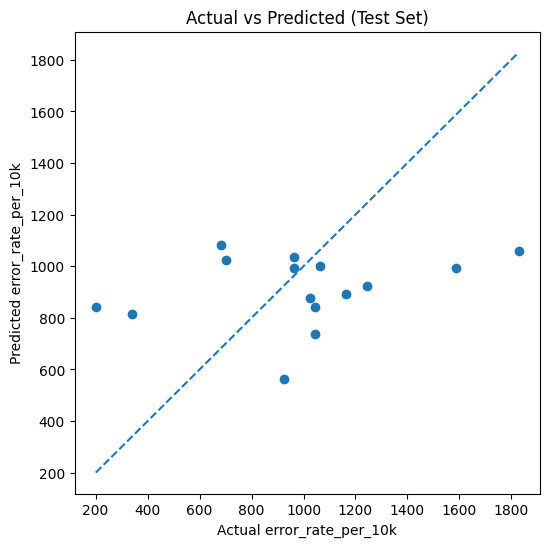

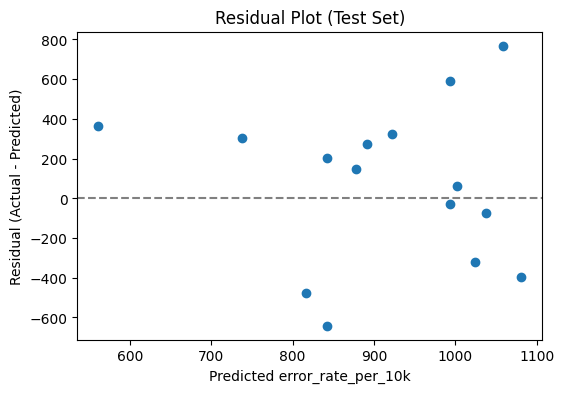

In [54]:
import matplotlib.pyplot as plt

best_model = rf_model  # or lin_model, pois_model

y_pred_test = best_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Actual error_rate_per_10k")
plt.ylabel("Predicted error_rate_per_10k")
plt.title("Actual vs Predicted (Test Set)")
plt.show()

# Residual plot
residuals = y_test - y_pred_test

plt.figure(figsize=(6,4))
plt.scatter(y_pred_test, residuals)
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Predicted error_rate_per_10k")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot (Test Set)")
plt.show()

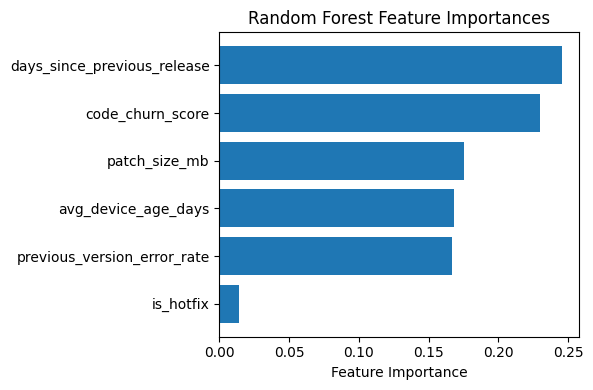

In [55]:
import numpy as np

importances = rf_model.feature_importances_
idx = np.argsort(importances)

plt.figure(figsize=(6,4))
plt.barh(np.array(feature_cols)[idx], importances[idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

In [56]:
from sklearn.ensemble import GradientBoostingRegressor

In [57]:
from xgboost import XGBRegressor

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

results = {}

# --------------------------
# 1. Linear Regression
# --------------------------
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

results['LinearRegression'] = {
    "RMSE": np.sqrt(mean_squared_error(y_test, lr_preds)),
    "R2": r2_score(y_test, lr_preds)
}

# --------------------------
# 2. Random Forest Regressor
# --------------------------
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

results['RandomForest'] = {
    "RMSE": np.sqrt(mean_squared_error(y_test, rf_preds)),
    "R2": r2_score(y_test, rf_preds)
}

# --------------------------
# 3. Gradient Boosting Regressor
# --------------------------
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gbr.fit(X_train, y_train)
gbr_preds = gbr.predict(X_test)

results['GradientBoosting'] = {
    "RMSE": np.sqrt(mean_squared_error(y_test, gbr_preds)),
    "R2": r2_score(y_test, gbr_preds)
}

# --------------------------
# 4. XGBoost Regressor
# --------------------------
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

results['XGBoost'] = {
    "RMSE": np.sqrt(mean_squared_error(y_test, xgb_preds)),
    "R2": r2_score(y_test, xgb_preds)
}

results

{'LinearRegression': {'RMSE': np.float64(413.18887441079175),
  'R2': -0.07119584865524442},
 'RandomForest': {'RMSE': np.float64(389.3733913051103),
  'R2': 0.04872916455556486},
 'GradientBoosting': {'RMSE': np.float64(415.90645389982217),
  'R2': -0.08533288474711354},
 'XGBoost': {'RMSE': np.float64(424.3679877160065), 'R2': -0.1299438778185409}}

In [59]:
# Save final ML feature set
features.to_csv(PROCESSED_DATA_DIR / "firmware_features_ml.csv", index=False)

print(f"✅ Saved firmware_features_ml.csv to {PROCESSED_DATA_DIR}")
print(f"   - {len(features)} firmware versions with {len(features.columns)} features")

✅ Saved firmware_features_ml.csv to /Users/hc/Documents/projects/roku-patch-stability-analytics/data/Processed
   - 50 firmware versions with 14 features


## Validation Visualizations

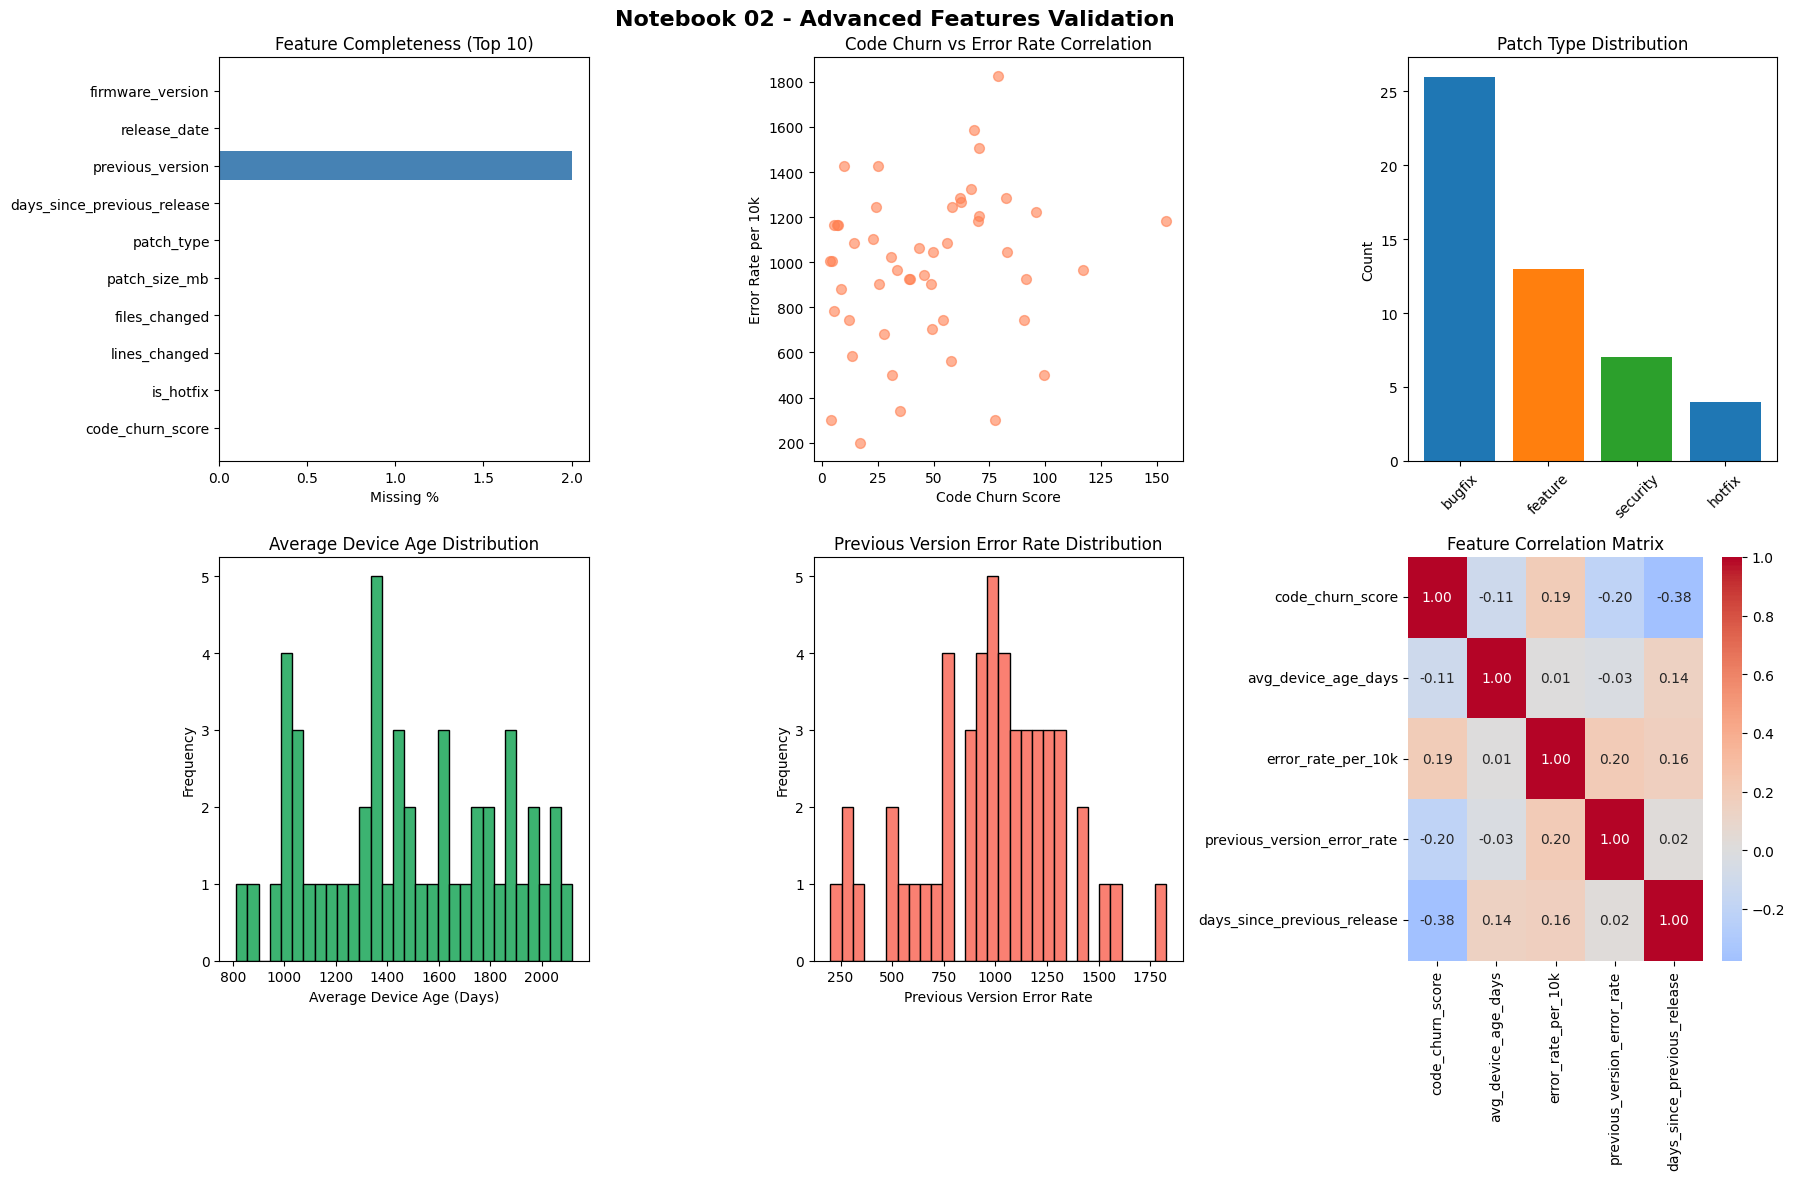


VALIDATION SUMMARY - Advanced Features
Total firmware versions: 50
Total features: 14
Missing values: 1

Patch type breakdown:
  bugfix: 26 (52.0%)
  feature: 13 (26.0%)
  security: 7 (14.0%)
  hotfix: 4 (8.0%)

Code churn score range: [3.78, 154.36]
Average device age range: [813, 2119] days
Error rate range: [200.80, 1827.31] per 10k


In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the final feature set for validation
features = pd.read_csv(PROCESSED_DATA_DIR / "firmware_features_ml.csv")

# Create comprehensive validation visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Notebook 02 - Advanced Features Validation', fontsize=16, fontweight='bold')

# 1. Feature completeness check
feature_completeness = features.isnull().sum() / len(features) * 100
axes[0, 0].barh(feature_completeness.index[:10], feature_completeness.values[:10], color='steelblue')
axes[0, 0].set_xlabel('Missing %')
axes[0, 0].set_title('Feature Completeness (Top 10)')
axes[0, 0].invert_yaxis()

# 2. Code churn vs error rate correlation
axes[0, 1].scatter(features['code_churn_score'], features['error_rate_per_10k'], 
                   alpha=0.6, c='coral', s=50)
axes[0, 1].set_xlabel('Code Churn Score')
axes[0, 1].set_ylabel('Error Rate per 10k')
axes[0, 1].set_title('Code Churn vs Error Rate Correlation')

# 3. Patch type distribution
patch_counts = features['patch_type'].value_counts()
axes[0, 2].bar(patch_counts.index, patch_counts.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Patch Type Distribution')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Device age distribution
if 'avg_device_age_days' in features.columns:
    axes[1, 0].hist(features['avg_device_age_days'], bins=30, color='mediumseagreen', edgecolor='black')
    axes[1, 0].set_xlabel('Average Device Age (Days)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Average Device Age Distribution')
else:
    axes[1, 0].text(0.5, 0.5, 'Device age not available', 
                    ha='center', va='center', transform=axes[1, 0].transAxes)

# 5. Previous version error rate distribution
if 'previous_version_error_rate' in features.columns:
    axes[1, 1].hist(features['previous_version_error_rate'].dropna(), bins=30, color='salmon', edgecolor='black')
    axes[1, 1].set_xlabel('Previous Version Error Rate')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Previous Version Error Rate Distribution')
else:
    axes[1, 1].text(0.5, 0.5, 'Previous error rate not available', 
                    ha='center', va='center', transform=axes[1, 1].transAxes)

# 6. Feature correlation heatmap (selected features)
selected_cols = ['code_churn_score', 'avg_device_age_days', 'error_rate_per_10k', 
                 'previous_version_error_rate', 'days_since_previous_release']
available_cols = [col for col in selected_cols if col in features.columns]
if len(available_cols) >= 3:
    corr_matrix = features[available_cols].corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[1, 2])
    axes[1, 2].set_title('Feature Correlation Matrix')
else:
    axes[1, 2].text(0.5, 0.5, 'Insufficient features for correlation', 
                    ha='center', va='center', transform=axes[1, 2].transAxes)

plt.tight_layout()
plt.show()

# Print validation summary
print("\n" + "="*60)
print("VALIDATION SUMMARY - Advanced Features")
print("="*60)
print(f"Total firmware versions: {len(features)}")
print(f"Total features: {len(features.columns)}")
print(f"Missing values: {features.isnull().sum().sum()}")
print(f"\nPatch type breakdown:")
for patch_type, count in patch_counts.items():
    print(f"  {patch_type}: {count} ({count/len(features)*100:.1f}%)")
print(f"\nCode churn score range: [{features['code_churn_score'].min():.2f}, {features['code_churn_score'].max():.2f}]")
if 'avg_device_age_days' in features.columns:
    print(f"Average device age range: [{features['avg_device_age_days'].min():.0f}, {features['avg_device_age_days'].max():.0f}] days")
print(f"Error rate range: [{features['error_rate_per_10k'].min():.2f}, {features['error_rate_per_10k'].max():.2f}] per 10k")
print("="*60)